In [7]:
from common import Data, NWSL, Colors, Fonts, add_twitter_handle
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from random import randrange
import datetime

In [2]:
df = Data.get_nwsl_players()
df

,name,position,birthday,country,hometown,number,height
0,Abby Dahlkemper,Defender,1993-05-13,USA,Lancaster,2.0,"5'6"""
1,Abby Elinsky,Midfielder,1996-01-08,USA,West Chester,20.0,"5'8"""
2,Abby Erceg,Defender,1989-11-20,New Zealand,Whangarei,20.0,"5'9"""
3,Abby Smith,Goalkeeper,1993-10-04,USA,Plano,4.0,"5'8"""
4,Abby Wambach,Attacker,1980-06-02,USA,NaN,NaN,"5'11"""
...,...,...,...,...,...,...,...
899,Zoe Morse,Defender,1998-04-01,USA,NaN,14.0,"5'8"""
900,Zoe Redei,Attacker,1997-10-08,USA,Atlanta,22.0,"5'4"""
901,Zoey Goralski,Defender,1995-01-22,USA,Naperville,28.0,"5'2"""
902,Zsanett Kaján,Attacker,1997-09-16,Hungary,NaN,55.0,NaN


In [3]:
df = (
    Data.get_nwsl_player_stats(include_early=True)[
        ["season", "date", "team", "player", "mins_played"]
    ]
    .set_index(["player"])
    .join(Data.get_nwsl_players()[["name", "birthday"]].set_index(["name"]))
    .dropna()
)
df

,season,date,team,mins_played,birthday
player,,,,,
Abby Dahlkemper,2015,2015-04-12,WNY,86.0,1993-05-13
Abby Dahlkemper,2015,2015-04-18,WNY,77.0,1993-05-13
Abby Dahlkemper,2015,2015-05-02,WNY,90.0,1993-05-13
Abby Dahlkemper,2015,2015-05-08,WNY,90.0,1993-05-13
Abby Dahlkemper,2015,2015-05-14,WNY,90.0,1993-05-13
...,...,...,...,...,...
Évelyne Viens,2021,2021-09-25,NJNY,9.0,1997-02-06
Évelyne Viens,2021,2021-10-06,NJNY,17.0,1997-02-06
Évelyne Viens,2021,2021-10-17,NJNY,1.0,1997-02-06


In [4]:
# Add random miliseconds to birthday timestamp to differentiate order for players with the same birthday
for player in df.index:
    df.loc[player, "birthday"] = df.loc[player, "birthday"] + datetime.timedelta(
        milliseconds=randrange(100)
    )
len(df["birthday"].unique()) == len(df.index.unique())

True

In [5]:
dates = sorted(df["date"].unique())
df["date_idx"] = df["date"].apply(
    lambda x: dates.index(x)
    + (10 * (x.year - 2013 if x.year < 2020 else x.year - 2014))
)

df = df.sort_values("birthday", ascending=True)
df["birthday_idx"] = 0
prev_year = df["birthday"].min().year
prev_player = df.iloc[0].name
idx = 0

for i, row in df.iterrows():
    if i == prev_player:
        df.loc[i, "birthday_idx"] = idx
    elif row["birthday"].year == prev_year:
        prev_player = i
        idx += 1
        df.loc[i, "birthday_idx"] = idx
    else:
        prev_player = i
        prev_year = row["birthday"].year
        idx += 20
        df.loc[i, "birthday_idx"] = idx

df["color"] = df["team"].apply(NWSL.color)

<Figure size 12800x12800 with 0 Axes>

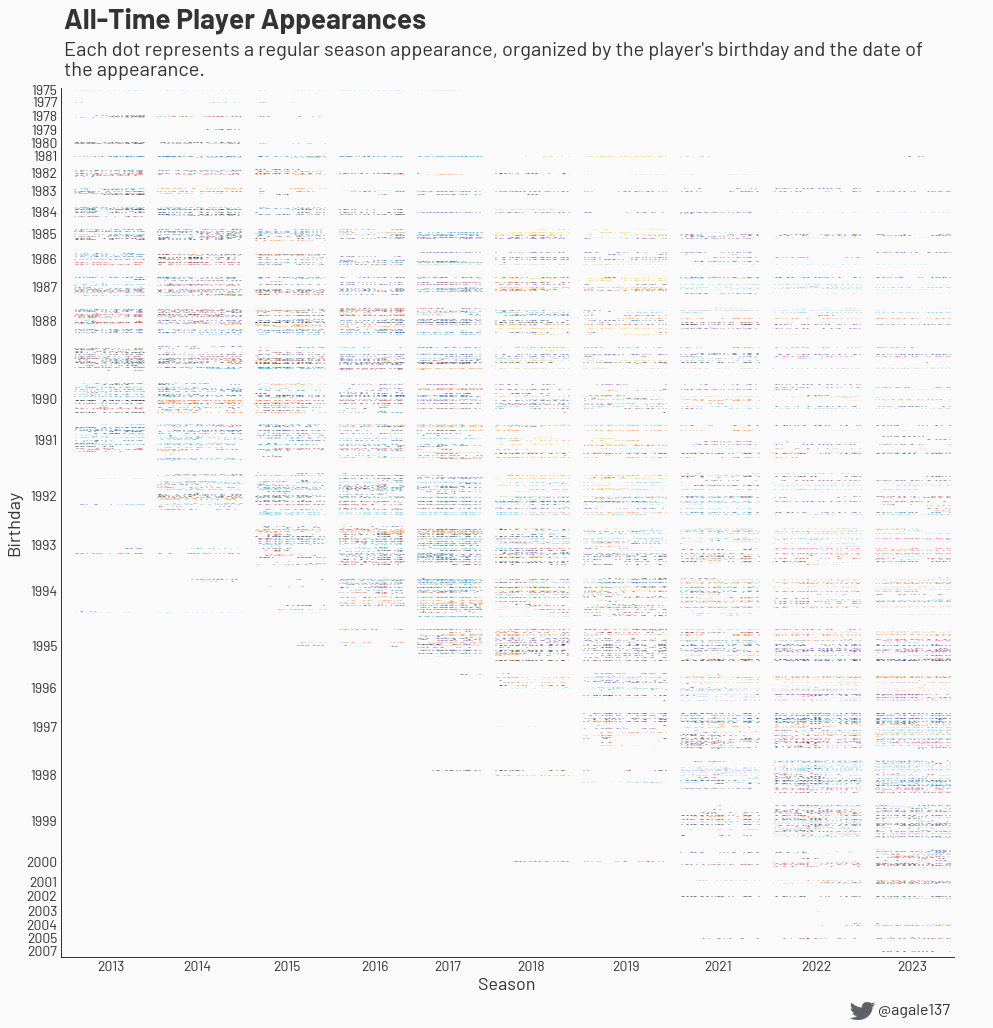

In [17]:
# Setup
plt.rcParams["figure.figsize"] = (16, 16)
plt.figure(dpi=800)
fig, ax = plt.subplots()
fig.patch.set_facecolor(Colors.WHITE)
ax.set_facecolor(Colors.WHITE)

# Plot data
ax.scatter(df["date_idx"], df["birthday_idx"], c=df["color"], marker="_", s=2, linewidths=0.5)

# Handle axes
ax.invert_yaxis()
ax.set_ylim(df["birthday_idx"].max() + 10, df["birthday_idx"].min() - 3)
ax.set_xlim(df["date_idx"].min() - 10, df["date_idx"].max() + 3)

# Tick labels
ax.tick_params(axis="both", which="both", length=0)
yticks = []
ytick_labels = []
for year in range(1975, 2010, 1):
    subset = df[df["birthday"].dt.year == year].sort_values("birthday", ascending=True)
    if len(subset.index) > 0:
        yticks.append(subset.iloc[int(len(subset.index) / 2)]["birthday_idx"])
        ytick_labels.append(year)

ax.set_yticks(yticks)
ax.set_yticklabels(
    ytick_labels,
    fontproperties=Fonts.BARLOW,
    size=14,
    color=Colors.BLACK,
)

xticks = []
xtick_labels = []
for year in range(2013, 2024, 1):
    subset = df[df["date"].dt.year == year].sort_values("date", ascending=True)
    if len(subset.index) > 0:
        xticks.append(subset.iloc[int(len(subset.index) / 2)]["date_idx"])
        xtick_labels.append(year)

ax.set_xticks(xticks)
ax.set_xticklabels(
    xtick_labels,
    fontproperties=Fonts.BARLOW,
    size=14,
    color=Colors.BLACK,
)


ax.spines[["right", "top"]].set_visible(False)

ax.set_xlabel(
    "Season",
    fontproperties=Fonts.BARLOW,
    size=18,
    color=Colors.BLACK,
)
ax.set_ylabel(
    "Birthday",
    fontproperties=Fonts.BARLOW,
    size=18,
    color=Colors.BLACK,
)

# Titles
plt.suptitle(
    "All-Time Player Appearances",
    x=0.285,
    y=0.95,
    fontproperties=Fonts.BARLOW_BOLD,
    fontsize=28,
    color=Colors.BLACK,
)
plt.figtext(
    0.128,
    0.89,
    "Each dot represents a regular season appearance, organized by the player's birthday and the date of\nthe appearance.",
    fontproperties=Fonts.BARLOW,
    fontsize=20,
    color=Colors.BLACK,
)

add_twitter_handle(fig, x=0.81, y=0.07, fs=16, w=0.018)

# Save image
plt.savefig(
    "all_time_appearances_hline.png",
    bbox_inches="tight",
    pad_inches=0.5,
    dpi=800,
)